There were suspicions that the range of values for different tracks (CAGE, ATAC-seq, DNAse and CHIP-seq) vary. If one track in general has higher values, then the predictions corresponding to this track may have a higher influence on the Deep Learning model's predictions. To assess whether this is the case, this file has code to plot the Enformer predictions, split by the four track types for ~ 1300 samples.

In [1]:
import pandas as pd
import numpy as np
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df = pd.read_csv(targets_txt, sep='\t')

for i in range(0, len(df)):
    description = df["description"][i]
    type = description.split(':')[0]
    df["description"][i] = type

dnaseList = df.index[df['description'] == "DNASE"].tolist()
chipList = df.index[df["description"] == "CHIP"].tolist()
atacList = df.index[df["description"] == "ATAC"].tolist()
cageList = df.index[df["description"] == "CAGE"].tolist()
print(len(dnaseList))
print(len(chipList))
print(len(atacList))
print(len(cageList))

/scratch/27570911/ipykernel_68644/1333969885.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["description"][i] = type


674
3991
10
638


In [3]:
filepath = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/enformer_output_training_1269.hdf5" 

def getTypeAssignedDf(indicesList, outputType):
    #Since outputs from 2 bins are concatenated, the same type of output occurs twice with a gap of 5313. 
    with h5py.File(filepath, 'r') as f:
        set1 = f["trainingEnformerOutput"][:, indicesList[0] : indicesList[-1] + 1]
        set2 = f["trainingEnformerOutput"][:, indicesList[0] + 5313 : indicesList[-1]+ 5314]
    
    flattedNumpyOutput = np.concatenate((set1, set2), axis = 1).flatten()
    print(f"shape of flattened numpy array for type {outputType} is {flattedNumpyOutput.shape}")
    typeDf = pd.DataFrame(flattedNumpyOutput, columns = ['enformerOutput'])
    typeDf = typeDf.assign(type=outputType)
    return typeDf

dnaseDf = getTypeAssignedDf(dnaseList, "DNASE")
chipDf = getTypeAssignedDf(chipList, "CHIP")
atacDf = getTypeAssignedDf(atacList, "ATAC")
cageDf = getTypeAssignedDf(cageList, "CAGE")

df1 = pd.concat([dnaseDf, chipDf])
df2 = pd.concat([atacDf, cageDf])
finalDf = pd.concat([df1, df2])
print(finalDf.shape)
finalDf.head(10)

shape of flattened numpy array for type DNASE is (1710612,)
shape of flattened numpy array for type CHIP is (10129158,)
shape of flattened numpy array for type ATAC is (25380,)
shape of flattened numpy array for type CAGE is (1619244,)
(13484394, 2)


,enformerOutput,type
0,0.004409,DNASE
1,0.004229,DNASE
2,0.007569,DNASE
3,0.003659,DNASE
4,0.004809,DNASE
5,0.005566,DNASE
6,0.004260,DNASE
7,0.005867,DNASE
8,0.004243,DNASE
9,0.005427,DNASE


<AxesSubplot: xlabel='enformerOutput', ylabel='type'>

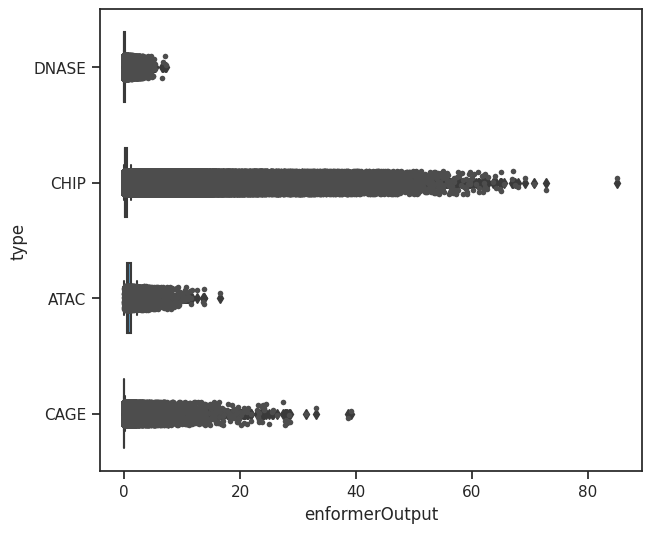

In [4]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="enformerOutput", y="type", data=finalDf, width=.6, color="skyblue", palette="Blues")

# Add in points to show each observation
sns.stripplot(x="enformerOutput", y="type", data=finalDf,
              size=4, color=".3", linewidth=0)